# **Tugas Pemodelan dan Simulasi Simulasi untuk Trafic Flow**
**Kelompok : 5** <br>
**Anggota    :** 
1.   Muhammad Avtara Khrisna (1301194094)
2.   Faiz Rofi Hencya (1301190230)
3.   Syifa Fauziah (1301194137)



In [ ]:
# Mengimport semua kebutuhan library
import matplotlib.pyplot as plt
import shutil
import os
import imageio as img

In [ ]:
import matplotlib.pyplot as plt
import shutil
import os
import imageio as img

# Kelas untuk membuat visualisasi
class visualization:
    # Inisialisasi variable kelas
    def __init__(self):
        self.fig, self.ax = plt.subplots(figsize=(8, 8))
        self.number_of_images = 0
        self.directory = "hasil"
        self.file_names = []

    def show(self):
        plt.figure(self.fig.number)
        plt.show()

    # Method untuk membuat direktori untuk menyimpan hasil
    def create_directory(self):
        try:
            shutil.rmtree(self.directory)
        except FileNotFoundError:
            pass
        os.mkdir(self.directory)

    # Method untuk menyimpan gambar setiap iterasi
    def save(self):
        path = os.path.join(self.directory, 
                            'step_{0:0>4}.png'.format(self.number_of_images))
        self.fig.savefig(path)
        self.number_of_images += 1
        self.file_names.append(path)

    # Method untuk membuat gif dari iterasi yang telah dibuat
    def gif(self, fps=2):
        images = []
        path = os.path.join(self.directory, 'simulation.gif')
        for file_name in self.file_names:
            images.append(img.imread(file_name))
        img.mimsave(path, images, fps=fps)

In [ ]:
from typing import Optional, List
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs


# Kelas Car untuk membuat objek mobil beserta kecepatan dan warna
class Car:
    def __init__(self, number, hue):
        self.velocity = 0
        self.number = number
        # color: warna yang akan dihasilkan untuk setiap mobil ini akan berbeda
        self.hue = hue  

    def __repr__(self):
        return 'Car ' + str(self.number)

# implementasi Model menggunakan Nagel-Schreckenberg Model
class Model:
    # Mendeklarasikan tipe data dari jalanan adalah List berisi objek mobil
    road: List[Optional[Car]]  
    
    def __init__(self, L, car_density, max_velocity, slowing_probability
                 , save_graphics=False):
        self.L = L
        self.car_density = car_density
        self.max_velocity = max_velocity
        self.slowing_probability = slowing_probability
        # Memproduksi mobil
        self.number_of_cars = int(
            round(L * car_density))
        # Membuat list jalanan apabila tidak ada mobil akan dibuat None
        self.road = [None] * L  
        self.average_velocities = []
        initial_car_indices = sorted(
            # Taruh random letak mobil yang ada dijalanan
            np.random.choice(L, self.number_of_cars, replace=False))  
        for i in range(len(initial_car_indices)):
            this_car = Car(i + 1, i / self.number_of_cars)
            self.road[initial_car_indices[i]] = this_car
        # Tanda untuk menyimpan visual pada setiap iterasinya
        self.save_graphics = save_graphics
        if save_graphics:
            self.drawing_machine = visualization()
            self.drawing_machine.create_directory()

    # Method untuk mendapatkan velocity
    def get_velocities(self):
        velocities = [None] * len(self.road)
        for i in range(len(self.road)):
            if self.road[i]:
                velocities[i] = self.road[i].velocity
        return velocities

    # Method untuk menjalankan simulasi traffic flow
    def simulation(self, number_of_iterations):  
        self.average_velocities = [self.average_velocity()]
        for i in range(number_of_iterations):
            self.acceleration()
            self.slowing()
            self.randomization()
            self.motion()
            self.average_velocities.append(self.average_velocity())
            if self.save_graphics:
                self.draw_road(r_big=4.5, r_small=4, t=i)
                plt.cla()
        if self.save_graphics:
            self.drawing_machine.gif(fps=10)

    # Method untuk mendefinisikan velocity di awal iterasi
    def acceleration(self):  
        for cell in self.road:
            if cell:
                cell.velocity = min(cell.velocity + 1, self.max_velocity)

    # Method untuk melambatkan pergerakan mobil berdasarkan 
    def slowing(self):
        for i in range(len(self.road)):
            if self.road[i]:
                distance = 0
                while not self.road[(i + distance + 1) % len(self.road)]:
                    distance += 1
                self.road[i].velocity = min(self.road[i].velocity, distance)

    # Method untuk random kecepatan dari mobil
    def randomization(self): 
        for i in range(len(self.road)):
            if self.road[i]:
                if np.random.random() < self.slowing_probability:
                    self.road[i].velocity = max(self.road[i].velocity - 1, 0)

    # Method untuk memperbaharui pergerakan dari mobil
    def motion(self):
        new_road = [None] * len(self.road)
        for i in range(len(self.road)):
            if self.road[i]:
                new_road[(i + self.road[i].velocity) % len(self.road)] = self.road[i]
        self.road = new_road

    # Menghitung rata-rata velocity dari setiap iterasi
    def average_velocity(self):  
        return sum(filter(None, self.get_velocities())) / self.number_of_cars

    # Method untuk visualisasi traffic flow
    def draw_road(self, r_big, r_small, t):  
        r_diff = r_small * np.sin(np.pi / self.L) / (1 - np.sin(np.pi / self.L))
        big_circle = plt.Circle((0, 0), r_big, color='darkgray')
        small_circle = plt.Circle((0, 0), r_small, color='w')
        self.drawing_machine.ax.add_artist(big_circle)
        self.drawing_machine.ax.add_artist(small_circle)
        plt.xlim(-(r_big + 2), (r_big + 2))
        plt.ylim(-(r_big + 2), (r_big + 2))
        r_middle = (r_big + r_small) / 2
        theta = np.linspace(0, 2 * np.pi, self.L + 1)
        for i in range(self.L):
            if self.road[i]:
                x = r_middle * np.cos(theta[i])
                y = r_middle * np.sin(theta[i])
                color = clrs.hsv_to_rgb((self.road[i].hue, 1, 1))
                car_circle = plt.Circle((x, y), 0.9 * r_diff, color=color)
                self.drawing_machine.ax.add_artist(car_circle)
        self.drawing_machine.ax.get_xaxis().set_ticks([])
        self.drawing_machine.ax.get_yaxis().set_ticks([])
        self.drawing_machine.ax.set_title(
            'Panjang lintasan={0}, Iterasi ke-{1}'.format(self.L, t))
        self.drawing_machine.ax.set_xlabel(
            'Populasi Mobil={0}, Max Velocity={1}, Slowing prob={2}'.format(
            int(round(self.car_density * self.L)),
            self.max_velocity,
            self.slowing_probability))
        self.drawing_machine.save()

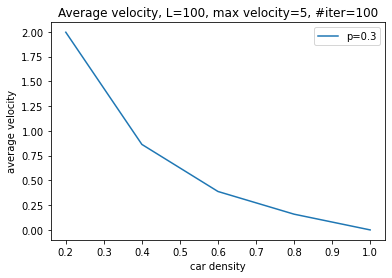

In [ ]:
if __name__ == '__main__':

    L = 100
    n_iterations = 100
    v_max = 5
    slowing_p_list = [0.3]
    rho_list = np.linspace(0.2, 1, 5)
    for p in slowing_p_list:
        average_velocities_list = []
        for rho in rho_list:
            NSM = Model(L, rho, v_max, p, save_graphics=False)
            NSM.simulation(n_iterations)
            average_velocities_list.append(sum(NSM.average_velocities) / len(NSM.average_velocities))
        plt.plot(rho_list, average_velocities_list, label='p={0}'.format(p))
    plt.title('Average velocity, L={0}, max velocity={1}, #iter={2}'.format(L, v_max, n_iterations))
    plt.xlabel('car density')
    plt.ylabel('average velocity')
    plt.legend()
    plt.show()

   

Kecepatan rata-rata: 
2.1282178217821777
Waktu rata-rata mobil kembali ke posisi awal: 
46.987671551523626


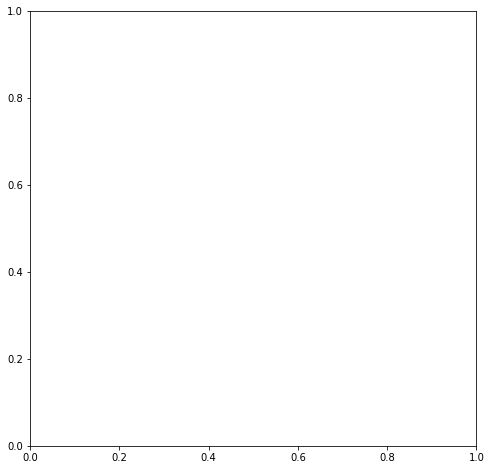

In [ ]:
if __name__ == '__main__':
    M = 100
    n_iterations = 100
    v_max = 5
    slowing_p = 0.3
    density = 0.2
    NSM = Model(M, density, v_max, slowing_p, save_graphics=True)
    NSM.simulation(n_iterations)
    
    print("Kecepatan rata-rata: ")
    print((sum(NSM.average_velocities) / len(NSM.average_velocities)))

    print("Waktu rata-rata mobil kembali ke posisi awal: ")
    print(M/(sum(NSM.average_velocities) / len(NSM.average_velocities)))